In [1]:
# librerias
from loguru import logger
import pandas as pd

import matplotlib.pyplot as plt
import seaborn as sns

import warnings
warnings.filterwarnings("ignore")
pd.set_option('display.max_columns', 500)
pd.set_option('display.max_rows', 500)
pd.set_option('display.float_format', lambda x: '%.3f' % x)

## Lectura de datos

In [2]:
logger.info("Leer Datos")

# paths
path_raw = "../../data/raw/"
path_procesed = "../../data/procesed/"
path_final = "../../data/final/"

2024-04-02 22:32:36.747 | INFO     | __main__:<module>:1 - Leer Datos


In [3]:
# leer datos
train = pd.read_csv(path_procesed + "train.csv")
test = pd.read_csv(path_procesed + "test.csv")

In [4]:
columns_to_convert = ['Pclass', 'SibSp','Parch']
train[columns_to_convert] = train[columns_to_convert].astype(str)
test[columns_to_convert] = test[columns_to_convert].astype(str)

In [5]:
# Obtener nombres de columnas según tipos de datos
variable_objetivo = 'Survived'

columnas_flotantes = [x for x in list(train.select_dtypes(include=['float64']).columns) if x!=variable_objetivo]
columnas_enteras = [x for x in list(train.select_dtypes(include=['int32', 'int64']).columns) if x!=variable_objetivo] 
columnas_objetos =  [x for x in list(train.select_dtypes(include=['object']).columns) if x!=variable_objetivo] 

## Modelos

In [6]:
import joblib
import time

from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier
from sklearn.svm import SVC
from sklearn.linear_model import LogisticRegression
from sklearn.neighbors import KNeighborsClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.naive_bayes import GaussianNB
from sklearn.ensemble import AdaBoostClassifier
from lightgbm import LGBMClassifier

from sklearn.metrics import (
    accuracy_score,
    precision_score,
    recall_score,
    f1_score,
    roc_curve,
    roc_auc_score,
)

from sklearn.model_selection import train_test_split
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.pipeline import Pipeline
from sklearn.impute import SimpleImputer

In [7]:
def train_and_evaluate_model(model, X_train, y_train, X_test, y_test):
    start_time = time.time()
    model.fit(X_train, y_train)
    execution_time = time.time() - start_time

    y_pred = model.predict(X_test)
    accuracy = round(accuracy_score(y_test, y_pred), 3)
    precision = round(precision_score(y_test, y_pred), 3)
    recall = round(recall_score(y_test, y_pred), 3)
    f1 = round(f1_score(y_test, y_pred), 3)

    y_prob = model.predict_proba(X_test)[:, 1]
    fpr, tpr, _ = roc_curve(y_test, y_prob, pos_label=-1)
    auc = round(roc_auc_score(y_test, y_prob), 3)

    evaluation_metrics = {
        "Accuracy": accuracy,
        "Precision": precision,
        "Recall": recall,
        "F1-Score": f1,
        "AUC": auc,
        "Time": round(execution_time, 3),
    }

    return evaluation_metrics


# Función para entrenar y evaluar cada modelo
def train_and_evaluate_all_models(models_dict, X_train, y_train, X_test, y_test):
    evaluation_results = {}
    for model_name, model in models_dict.items():
        evaluation_metrics = train_and_evaluate_model(
            model, X_train, y_train, X_test, y_test
        )
        evaluation_results[model_name] = evaluation_metrics

    # Convertir los resultados en un DataFrame
    results_df = pd.DataFrame.from_dict(evaluation_results, orient="index")
    return results_df


In [8]:
logger.info("Dividir el conjunto de datos en entrenamiento y prueba")

# Dividir los datos en entrenamiento y prueba
vo = 'Survived'
set_index='PassengerId'

features = [x for x in train.columns if x not in [vo,set_index]]

X = train[features]
y = train[vo]

# Dividir los datos en entrenamiento y prueba
X_train, X_test, y_train, y_test = train_test_split(X,y, test_size=0.2, random_state=42)

2024-04-02 22:32:37.121 | INFO     | __main__:<module>:1 - Dividir el conjunto de datos en entrenamiento y prueba


In [9]:
# Ejemplo de variables numéricas y categóricas
numeric_features = X.select_dtypes(include=['int64', 'float64']).columns.tolist()
categorical_features = X.select_dtypes(include=['object']).columns.tolist()

# Crear los transformadores para las variables numéricas y categóricas
numeric_transformer = Pipeline(steps=[
    ('imputer', SimpleImputer(strategy='median')),
    ('scaler', StandardScaler())
])
categorical_transformer = Pipeline(steps=[
    ('imputer', SimpleImputer(strategy='most_frequent')),
    ('onehot', OneHotEncoder(handle_unknown='ignore'))
])

# Crear el ColumnTransformer para aplicar las transformaciones en un pipeline
preprocessor = ColumnTransformer(
    transformers=[
        ('num', numeric_transformer, numeric_features),
        ('cat', categorical_transformer, categorical_features)
    ])

# Aplicar el preprocesamiento a los datos de entrenamiento y prueba
X_train_processed = preprocessor.fit_transform(X_train)
X_test_processed = preprocessor.transform(X_test)

# Obtener los nombres de las columnas después del preprocesamiento
numeric_feature_names = preprocessor.transformers_[0][-1]
categorical_feature_names = preprocessor.transformers_[1][-1]

# Obtener las categorías únicas de las variables categóricas
unique_categories = preprocessor.named_transformers_['cat']['onehot'].categories_

# Crear los nombres de las columnas después del OneHotEncoding
encoded_categorical_feature_names = []
for i, categories in enumerate(unique_categories):
    for category in categories:
        encoded_categorical_feature_names.append(f'{categorical_feature_names[i]}_{category}')
        
# Convertir la matriz dispersa a un DataFrame de Pandas
transformed_train_df = pd.DataFrame(X_train_processed.toarray(), columns=numeric_feature_names+ encoded_categorical_feature_names)
transformed_test_df = pd.DataFrame(X_test_processed.toarray(), columns=numeric_feature_names+ encoded_categorical_feature_names)

In [10]:
# Modelos con mejores hiperparámetros

# Inicialización del clasificador RandomForest con hiperparámetros optimizados
random_forest = RandomForestClassifier(random_state=42,
                                        n_estimators=100,
                                        max_depth=None,
                                        min_samples_split=2,
                                        min_samples_leaf=1)

# Inicialización del clasificador LGBM con hiperparámetros optimizados
lgbm = LGBMClassifier(random_state=42,
                      n_estimators=100,
                      learning_rate=0.1,
                      max_depth=-1)

# Inicialización del clasificador DecisionTree con hiperparámetros optimizados
decision_tree = DecisionTreeClassifier(random_state=42,
                                       max_depth=None,
                                       min_samples_split=2,
                                       min_samples_leaf=1)

# Inicialización del clasificador KNeighbors con hiperparámetros optimizados
knn = KNeighborsClassifier(n_neighbors=5,
                           weights='uniform',
                           p=2)

# Inicialización del clasificador LogisticRegression con hiperparámetros optimizados
logistic_regression = LogisticRegression(random_state=42,
                                         C=1.0,
                                         penalty='l2')


# Inicialización del clasificador GaussianNB con hiperparámetros optimizados
gaussian_nb = GaussianNB(var_smoothing=1e-9)

# Inicialización del clasificador AdaBoost con hiperparámetros optimizados
ada_boost = AdaBoostClassifier(random_state=42,
                               n_estimators=50,
                               learning_rate=0.1)

# Crear un diccionario de modelos con sus parámetros para facilitar la iteración
models = {
    'Random Forest': random_forest, 
    'LGBM': lgbm,
    'Decision Tree': decision_tree,
    'KNN': knn, 
    'Logistic Regression': logistic_regression,
    'GaussianNB': gaussian_nb,
    'AdaBoost': ada_boost
}


In [11]:
# Llamada a la función para entrenar y evaluar todos los modelos
logger.info("Entrenar y evaluar todos los modelos")
results_df = train_and_evaluate_all_models(models, transformed_train_df, y_train, transformed_test_df, y_test)

2024-04-02 22:32:37.183 | INFO     | __main__:<module>:2 - Entrenar y evaluar todos los modelos


[LightGBM] [Info] Number of positive: 268, number of negative: 444
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000146 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 208
[LightGBM] [Info] Number of data points in the train set: 712, number of used features: 20
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.376404 -> initscore=-0.504838
[LightGBM] [Info] Start training from score -0.504838
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best

In [12]:
# Mostrar el DataFrame con los resultados
logger.info("Ordenar los resultados por la métrica AUC")
results_df.sort_values('AUC',ascending = False)

2024-04-02 22:32:37.603 | INFO     | __main__:<module>:2 - Ordenar los resultados por la métrica AUC


,Accuracy,Precision,Recall,F1-Score,AUC,Time
Random Forest,0.810,0.794,0.730,0.761,0.886,0.103
Logistic Regression,0.810,0.786,0.743,0.764,0.875,0.014
KNN,0.821,0.809,0.743,0.775,0.872,0.001
LGBM,0.793,0.768,0.716,0.741,0.871,0.101
AdaBoost,0.788,0.757,0.716,0.736,0.866,0.056
Decision Tree,0.788,0.743,0.743,0.743,0.788,0.003
GaussianNB,0.419,0.415,0.986,0.584,0.778,0.001


In [13]:
logger.info("Seleccionar modelo")

#model = LGBMClassifier(random_state=42)
model = RandomForestClassifier(random_state=42)

model.fit(transformed_train_df, y_train)

2024-04-02 22:32:37.619 | INFO     | __main__:<module>:1 - Seleccionar modelo


RandomForestClassifier(random_state=42)

In [14]:
# Obtener los hiperparámetros
hiperparametros =  model.get_params()
print(hiperparametros)

{'bootstrap': True, 'ccp_alpha': 0.0, 'class_weight': None, 'criterion': 'gini', 'max_depth': None, 'max_features': 'sqrt', 'max_leaf_nodes': None, 'max_samples': None, 'min_impurity_decrease': 0.0, 'min_samples_leaf': 1, 'min_samples_split': 2, 'min_weight_fraction_leaf': 0.0, 'monotonic_cst': None, 'n_estimators': 100, 'n_jobs': None, 'oob_score': False, 'random_state': 42, 'verbose': 0, 'warm_start': False}


In [15]:
# Obtener la importancia de las características
feature_importance = model.feature_importances_

# Obtener los nombres de las características
feature_names = transformed_train_df.columns

# Crear un DataFrame con las características y su importancia
feature_importance_df = pd.DataFrame({'Feature': feature_names, 'Importance': feature_importance})

# Ordenar el DataFrame por importancia en orden descendente
feature_importance_df = feature_importance_df.sort_values(by='Importance', ascending=False)

In [16]:
# Mostrar las características más importantes
feature_importance_df

,Feature,Importance
0,Age,0.220
1,Fare,0.220
5,Sex_female,0.135
6,Sex_male,0.134
4,Pclass_3,0.044
28,Cabin_N,0.032
3,Pclass_2,0.020
2,Pclass_1,0.020
8,SibSp_1,0.017
32,Embarked_S,0.017


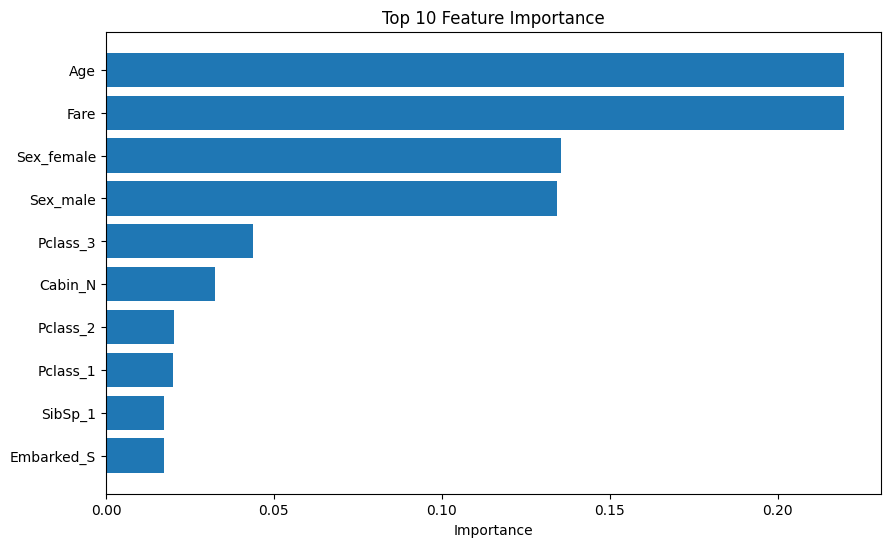

In [17]:
# Gráfico de barras para visualizar las características más importantes
plt.figure(figsize=(10, 6))
plt.barh(feature_importance_df['Feature'][:10], feature_importance_df['Importance'][:10])
plt.xlabel('Importance')
plt.title('Top 10 Feature Importance')
plt.gca().invert_yaxis()  # Invertir el eje y para que las características más importantes estén en la parte superior
plt.show()

In [18]:
logger.info("Realizar predicciones")

def preprocess_applier(preprocessor, X_data):
    # Aplicar el preprocesamiento a los datos
    X_data_processed = preprocessor.transform(X_data)

    # Obtener los nombres de las columnas después del preprocesamiento
    numeric_feature_names = preprocessor.transformers_[0][-1]
    categorical_feature_names = preprocessor.transformers_[1][-1]

    # Obtener las categorías únicas de las variables categóricas
    unique_categories = preprocessor.named_transformers_["cat"]["onehot"].categories_

    # Crear los nombres de las columnas después del OneHotEncoding
    encoded_categorical_feature_names = []
    for i, categories in enumerate(unique_categories):
        for category in categories:
            encoded_categorical_feature_names.append(
                f"{categorical_feature_names[i]}_{category}"
            )

    # Convertir la matriz dispersa a un DataFrame de Pandas
    transformed_df = pd.DataFrame(
        X_data_processed.toarray(),
        columns=numeric_feature_names + encoded_categorical_feature_names,
    )

    return transformed_df



X_test_processed2 = preprocess_applier(preprocessor, test.drop('PassengerId',axis=1))
predictions = model.predict(X_test_processed2)
test["Survived"] = predictions
test.head()

2024-04-02 22:32:37.902 | INFO     | __main__:<module>:1 - Realizar predicciones


,PassengerId,Pclass,Sex,Age,SibSp,Parch,Fare,Cabin,Embarked,Survived
0,892,3,male,34.500,0,0,7.829,N,Q,0
1,893,3,female,47.000,1,0,7.000,N,S,0
2,894,2,male,62.000,0,0,9.688,N,Q,0
3,895,3,male,27.000,0,0,8.662,N,S,1
4,896,3,female,22.000,1,1,12.287,N,S,0


In [19]:
logger.info("Guardar Resultados")

2024-04-02 22:32:37.931 | INFO     | __main__:<module>:1 - Guardar Resultados


In [20]:
logger.info("Guardar resultados de las predicciones")

test.to_csv(path_final + "predictions.csv",index=False,sep=',')

2024-04-02 22:32:37.946 | INFO     | __main__:<module>:1 - Guardar resultados de las predicciones


In [21]:
logger.info("Guardar resultados de los distintos modelos")

results_df.to_csv(path_final + "models_metrics.csv",index=False,sep=',')

2024-04-02 22:32:37.961 | INFO     | __main__:<module>:1 - Guardar resultados de los distintos modelos


In [22]:
logger.info("Guardar Modelo" )
path_models = "../models/"
joblib.dump(model, path_models + 'modelo_titanic_rf.pkl')

2024-04-02 22:32:37.976 | INFO     | __main__:<module>:1 - Guardar Modelo


['../models/modelo_titanic_rf.pkl']